In [1]:
import torch
import torch.nn as nn
import numpy as np
import datasets
from tqdm import trange


In [2]:
X_train, Y_train, X_test, Y_test = datasets.fetch_mnist()
X_train = X_train.reshape((-1, 1, 28, 28)) / 256.0
X_test = X_test.reshape((-1, 1, 28, 28)) / 256.0


class MNISTTrainDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.X = X_train
        self.Y = Y_train

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

    def __len__(self):
        return self.X.shape[0]


In [3]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv = nn.Conv2d(1, 32, (3, 3))
        self.pool = nn.MaxPool2d((2, 2))
        self.fc = nn.Sequential(
            nn.Linear(32 * 13 * 13, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        x = self.conv(x).relu()  # 32 channels x 26 x 26
        x = self.pool(x)  # 32 channels x 13 x 13
        x = self.fc(x.reshape(-1, 32 * 13 * 13))
        return x


In [12]:
# Training
mnist_dataset = MNISTTrainDataset()
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=256, shuffle=True)
model = Network()

optimizer = torch.optim.Adam(model.parameters(), 0.001)
loss_function = nn.NLLLoss()

for epoch in (t := trange(5)):

    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader, 0):
        data, target = data.float(), target.long()

        optimizer.zero_grad()

        out = model(data)
        loss = loss_function(out, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 20 == 19:
            t.set_description(
                f"[{epoch + 1} epochs, {batch_idx + 1} batches] loss: {running_loss / 20:.3f}"
            )
            running_loss = 0.0


[5 epochs,   220 batches] loss: 0.043: 100%|██████████| 5/5 [00:53<00:00, 10.61s/it]


In [13]:
# Evaluation
def eval():
    with torch.no_grad():
        X = torch.tensor(X_test[:]).float()
        Y = torch.tensor(Y_test[:]).long()
        out = model(X)
        accuracy = (torch.argmax(out, dim=1) == Y).float().mean()
    return accuracy.item()


print(f"accuracy: {eval()}")


accuracy: 0.9821000099182129


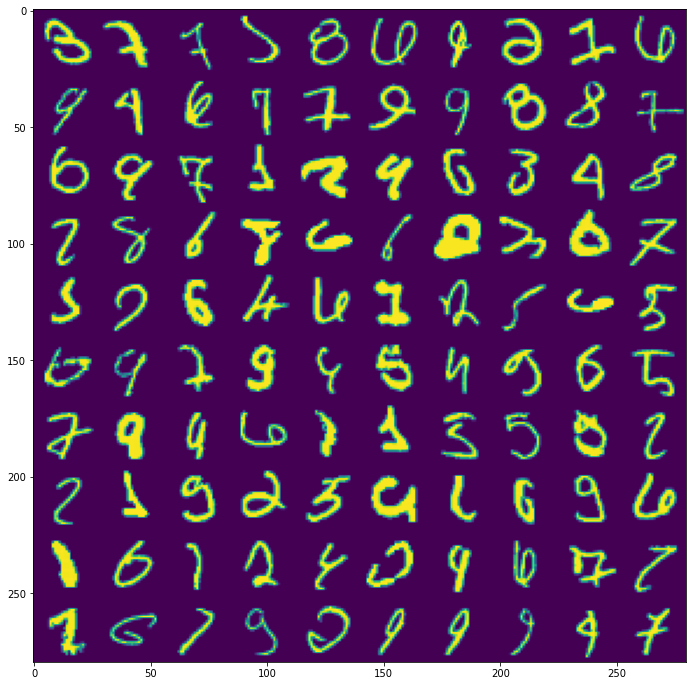

In [15]:
# The first 100 images that did not match with the models prediction
import matplotlib.pyplot as plt

G = 10

X = torch.tensor(X_test[:]).float()
Y = torch.tensor(Y_test[:]).long()

out = model(X)
bad_batch = [i for i, match in enumerate(torch.argmax(out, dim=1) == Y) if not match]
bad_batch = bad_batch[: G * G]

plt.figure(figsize=(12, 12))
plt.imshow(np.concatenate(X_test[bad_batch].reshape((G, G * 28, 28)), axis=1))
